# 因为都在前一个notebook中搞完了，所以这个只做成果展示

In [73]:
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import pandas as pd
import numpy as np
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
import lightgbm as lgb
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

def preprocess(X):
    """去除文字列"""
    X = X.iloc[:, 5:]
    return X

In [74]:
def normalize(X):
    """去归一化"""
    for col in X.columns:
        scaler = len(np.unique(X[col]))-1
        if scaler == 1: # 去除二元选择器
            X.drop(col, axis=1, inplace=True)
            continue
        temp: pd.Series = X[col]
        X[col] = temp.multiply(scaler).astype(int)
    return X

In [75]:
def pick_up_features(X: pd.DataFrame, y: pd.Series, score: float) -> tuple[pd.DataFrame, pd.Series]:
    """
    自动根据传入的目标指标筛选相关的关系最近n条指标（相关度阈值）

    :param X: 经过统一初始处理过的dataframe
    :param y: 选择预测的列
    :param score: 相关度阈值
    :return:
    """
    # X = X.iloc[:, 5:]
    # X = X.loc[:,X.max()<=1] # 筛选掉非离散变量
    # for col in X.columns:
    #     scaler = len(np.unique(X[col]))-1
    #     if scaler == 1: # 去除二元选择器
    #         X.drop(col, axis=1, inplace=True)
    #         continue
    #     temp: pd.Series = X[col]
    #     X[col] = temp.multiply(scaler).astype(int)
    try:
        X.drop(y.name, axis=1, inplace=True)
    except:
        print("没有该列")
    y = y.multiply(len(np.unique(y)-1)).astype(int)

    # 互信息算法
    selector_mi = SelectKBest(score_func=mutual_info_classif, k='all')
    selector_mi.fit_transform(X, y)

    mi_scores = pd.DataFrame({
        'feature': X.columns,
        'mutual_info_score': selector_mi.scores_
    }).sort_values('mutual_info_score', ascending=False)

    selected_features = mi_scores[mi_scores['mutual_info_score'] >= score]['feature'].tolist()

    X = X[selected_features]

    return X, y

In [81]:
def training_with_EMOTE_bayes_search(X, y) -> LGBMClassifier:
    """
    使用EMOTE进行过采样，并使用贝叶斯搜索进行超参数优化

    :param X: 训练集特征
    :param y: 训练集标签
    :return:
    """
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

    # 分割数据
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy={ 1: 200, 2: 800}, random_state=42)),
    ('tomek', TomekLinks())  # 在过采样后再应用Tomek
    ])
    X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

    base_params = {
            # 'device': 'gpu',
            # 'gpu_platform_id': 0,
            # 'gpu_device_id': 0,
            'objective': 'multiclass',
            'num_class': len(np.unique(y.values)),
            'metric': 'multi_logloss',
            'boosting_type': 'gbdt',
            'verbose': -1,
        }

    # 定义贝叶斯优化目标函数
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 30, 300),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'max_depth': trial.suggest_int('max_depth', 2, 12),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
            'min_child_weight': trial.suggest_float('min_child_weight', 1e-4, 0.1, log=True),
        }

        all_params = {**base_params, **params}
        lgb_model = lgb.LGBMClassifier(**all_params)

        # 分层k折验证
        stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = cross_val_score(lgb_model, X_resampled, y_resampled, cv=stratified_cv, scoring='f1_macro')

        return np.mean(scores)

    study = optuna.study.create_study(
        direction='maximize',  # 最大化准确率
        sampler=optuna.samplers.TPESampler(seed=42)  # 使用TPE采样器
    )
    print("开始贝叶斯优化...")
    study.optimize(objective, n_trials=100)  # 100次试验
    # 输出最佳结果
    print("\n🎉 优化完成！")
    print("最佳分数:", study.best_value)
    print("最佳参数:", study.best_params)

    # 用最佳参数训练最终模型
    best_params = {**base_params, **study.best_params}
    final_model = lgb.LGBMClassifier(**best_params)

    # 添加早停训练
    final_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        callbacks=[
            lgb.early_stopping(stopping_rounds=30, verbose=True),
            lgb.log_evaluation(50)
        ]
    )

    # 最终评估
    y_pred = final_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"\n📊 最终测试集准确率: {test_accuracy:.4f}")

    # 分析模型特征重要性
    feature_importance = final_model.feature_importances_
    feature_names = X_train.columns if hasattr(X_train, 'columns') else range(X_train.shape[1])

    # 排序并显示最重要的特征
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    print("Top 21重要特征:")
    print(importance_df.head(21))

    # 绘制学习曲线
    lgb.plot_metric(final_model)

    return final_model

In [79]:
def train(X: pd.DataFrame, y: pd.Series, score: float) -> LGBMClassifier:
    """
    开始训练
    :param X: 总数据集
    :param y: 目标指标
    :return: 训练好的lgb分类器
    """
    X = preprocess(X)
    X = normalize(X)
    X, y = pick_up_features(X, y, score)
    model = training_with_EMOTE_bayes_search(X, y)
    return model

[I 2025-08-24 21:01:22,868] A new study created in memory with name: no-name-a9a97ae1-e944-404b-8aa4-c10963fcf862


开始贝叶斯优化...


[I 2025-08-24 21:01:23,668] Trial 0 finished with value: 0.5920333694905977 and parameters: {'n_estimators': 131, 'learning_rate': 0.2536999076681772, 'num_leaves': 115, 'max_depth': 8, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 0.0017073967431528124, 'reg_lambda': 2.9154431891537547, 'min_child_samples': 32, 'min_child_weight': 0.013311216080736894}. Best is trial 0 with value: 0.5920333694905977.
[I 2025-08-24 21:01:23,804] Trial 1 finished with value: 0.5706349759985302 and parameters: {'n_estimators': 35, 'learning_rate': 0.2708160864249968, 'num_leaves': 129, 'max_depth': 4, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'reg_alpha': 0.016480446427978974, 'reg_lambda': 0.12561043700013558, 'min_child_samples': 24, 'min_child_weight': 0.0007476312062252305}. Best is trial 0 with value: 0.5920333694905977.
[I 2025-08-24 21:01:24,819] Trial 2 finished with value: 0.5690444102219668 and parameters: {'n_estimators': 19


🎉 优化完成！
最佳分数: 0.6079283599446305
最佳参数: {'n_estimators': 292, 'learning_rate': 0.13962563737015762, 'num_leaves': 143, 'max_depth': 11, 'subsample': 0.8391599915244341, 'colsample_bytree': 0.9687496940092467, 'reg_alpha': 0.002259279742015696, 'reg_lambda': 0.006080390190296602, 'min_child_samples': 7, 'min_child_weight': 0.0009462175356461491}
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's multi_logloss: 0.558694

📊 最终测试集准确率: 0.7845
Top 21重要特征:
     feature  importance
2    住宿条件满意度         474
0    教室设备满意度         456
3    网络资源满意度         452
6     图书馆满意度         444
9    劳动教育满意度         434
16  问题解决能力提升         422
1    体育设施满意度         417
17  班主任工作满意度         414
14   实习内容满意度         407
4     实训室满意度         398
8    职业规划满意度         394
13   体育教育满意度         390
10   教师总体满意度         388
11   心理健康满意度         386
15  思政课质量满意度         381
7      一站式服务         377
19     创造性思考         376
12  思政课总体满意度         371
5    学业指导满意

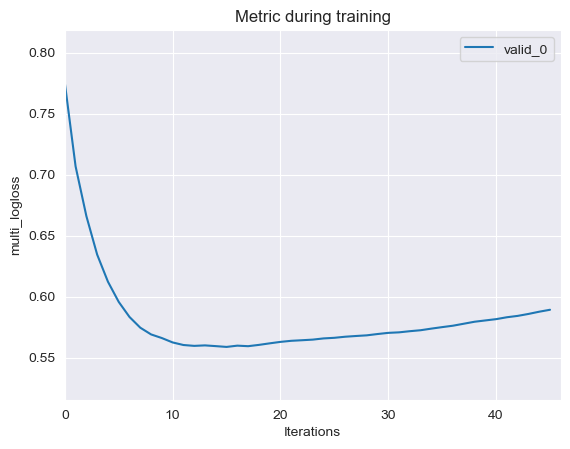

In [83]:
df = pd.read_csv("../../data/intermediate/初步清洗_比赛数据.csv")
model = train(df, df['学校整体满意度'], 0.162)
model.booster_.save_model("../../lgb_model.txt")